<a href="https://colab.research.google.com/github/munikumar229/es335-24-fall-assignment-2/blob/master/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Task-3

1. Super-resolution: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
import cv2
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# read image
img = torchvision.io.read_image("/content/dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


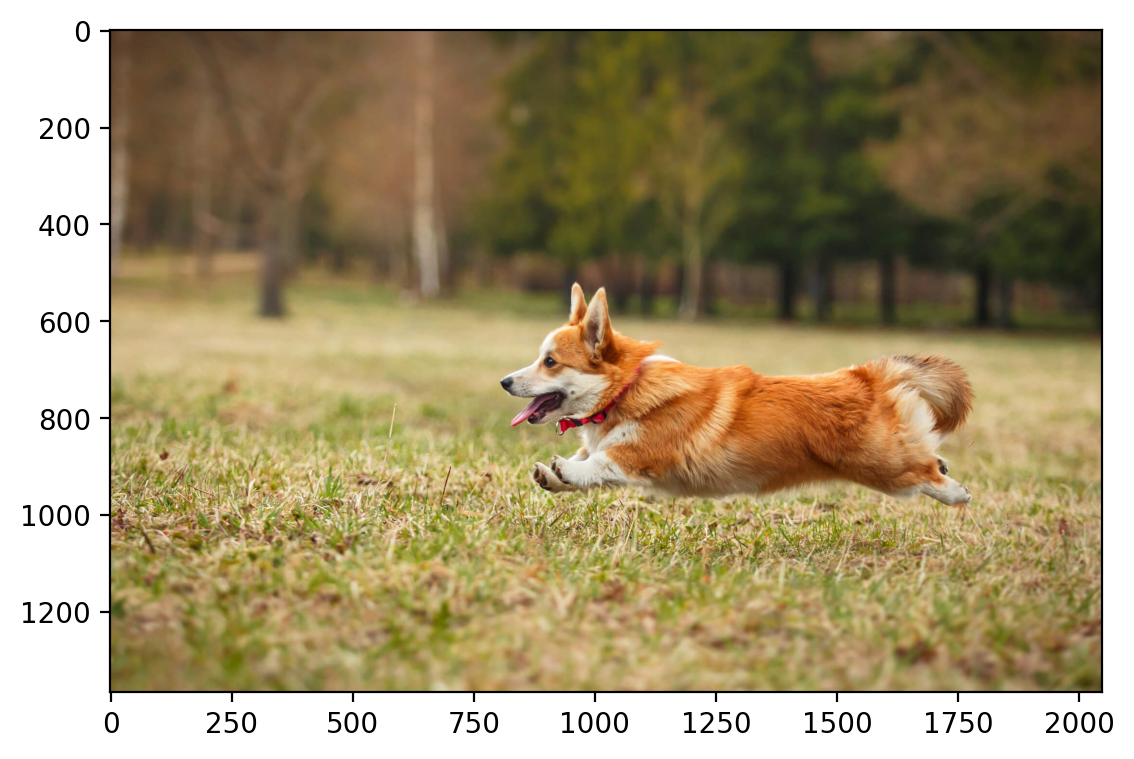

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [ ]:
# preprocessing image
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

(3, 1365, 2048)


tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [ ]:
# cropping original image into size 400x400
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop.shape

torch.Size([3, 400, 400])

In [ ]:
print(type(crop))

<class 'torch.Tensor'>


In [ ]:
# resize the image into 200x200
cropped_img_np = crop.numpy().transpose(1, 2, 0)
resized_img = cv2.resize(cropped_img_np, (200, 200),interpolation = cv2.INTER_CUBIC)
resized_img_tensor = torch.from_numpy(resized_img).permute(2, 0, 1)
print("Cropped shape:", crop.shape)
print("Resized shape:", resized_img_tensor.shape)

Cropped shape: torch.Size([3, 400, 400])
Resized shape: torch.Size([3, 200, 200])


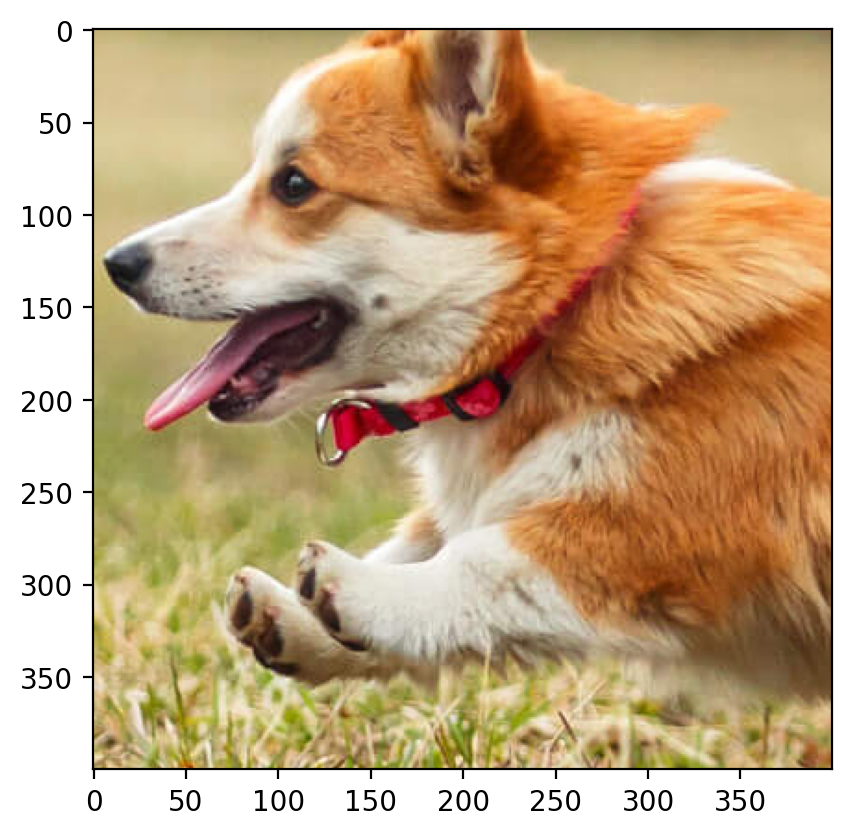

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

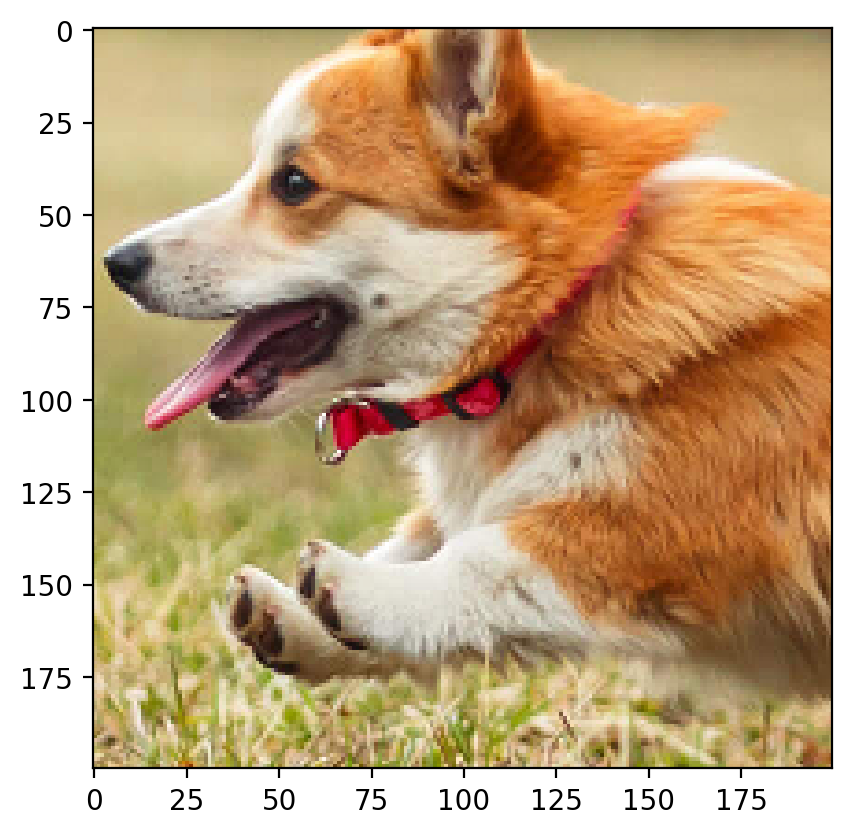

In [ ]:
plt.imshow(rearrange(resized_img_tensor, 'c h w -> h w c').cpu().numpy())

In [ ]:
# move to gpu if available
resized_img_tensor = resized_img_tensor.to(device)

In [ ]:
num_channels, height, width = resized_img_tensor.shape
print(num_channels, height, width)

3 200 200


In [ ]:
# Create a 2D grid of (x,y) coordinates (h, w)
def create_coordinate_map(img, scale):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y



In [ ]:
# coordinate map of 200x200 image
scale = 1
dog_X, dog_Y = create_coordinate_map(resized_img_tensor,scale)
dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [ ]:
# scaling the values
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()

In [ ]:
# linear model
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [ ]:
# function to train the linear model
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
# function for plotting the results
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
# function for creating Random Fourier Features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2),random_state=42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [ ]:
# create rff features for 200x200 image
X_rff = create_rff_features(dog_X_scaled, 90000,0.008)

In [ ]:
X_rff.shape

torch.Size([40000, 90000])

In [ ]:
# train the model
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.001, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.368424
Epoch 100 loss: 0.242266
Epoch 200 loss: 0.158926
Epoch 300 loss: 0.102553
Epoch 400 loss: 0.065142
Epoch 500 loss: 0.040830
Epoch 600 loss: 0.025343
Epoch 700 loss: 0.015662
Epoch 800 loss: 0.009712
Epoch 900 loss: 0.006104
Epoch 1000 loss: 0.003929
Epoch 1100 loss: 0.002612
Epoch 1200 loss: 0.001803
Epoch 1300 loss: 0.001290
Epoch 1400 loss: 0.000954
Epoch 1500 loss: 0.000725
Epoch 1600 loss: 0.000563
Epoch 1700 loss: 0.000447
Epoch 1800 loss: 0.000362
Epoch 1900 loss: 0.000299
Epoch 2000 loss: 0.000253
Epoch 2100 loss: 0.000220
Epoch 2200 loss: 0.000195
Epoch 2300 loss: 0.000178
Epoch 2400 loss: 0.000166


0.00015727028949186206

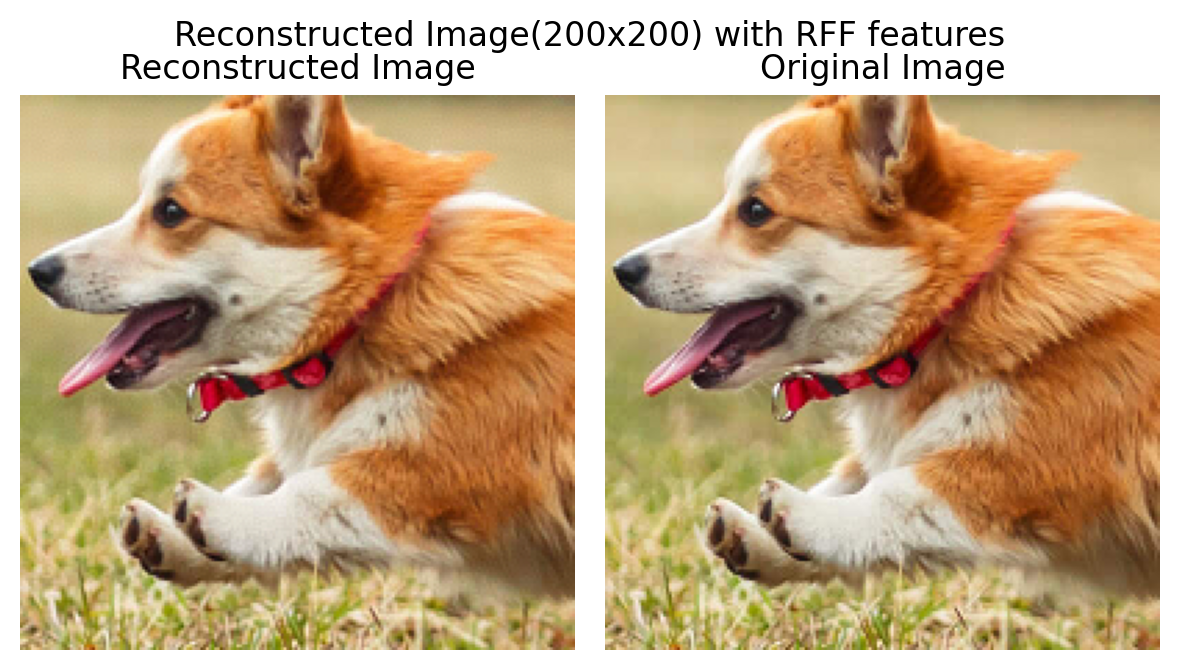

In [ ]:
# results for 200x200 image after training
plot_reconstructed_and_original_image(resized_img_tensor, net, X_rff, title="Reconstructed Image(200x200) with RFF features")

In [ ]:
resized_img_tensor.shape

torch.Size([3, 200, 200])

In [ ]:
# scale the 200x200 image by factor 2 to create coordinate map for 400x400 image
scale_factor = 2.0
high_res_X,y = create_coordinate_map(resized_img_tensor,scale_factor)
scaler_X2 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(high_res_X.cpu())
high_res_X_scaled = scaler_X2.transform(high_res_X.cpu())
high_res_X_scaled = torch.tensor(high_res_X_scaled, dtype=torch.float32).to(device)


In [ ]:
high_res_X_scaled.shape

torch.Size([160000, 2])

In [ ]:
# create rff features for the scaled data and ;redict the values for 400x400 image
high_res_X_rff = create_rff_features(high_res_X_scaled, 90000, 0.008)
net.eval()
with torch.no_grad():
    high_res_Y_pred = net(high_res_X_rff)


In [ ]:
high_res_X_rff.shape

torch.Size([160000, 90000])

In [ ]:
# reshape the predicted image
high_res_Y_pred = high_res_Y_pred.reshape(400, 400, 3)

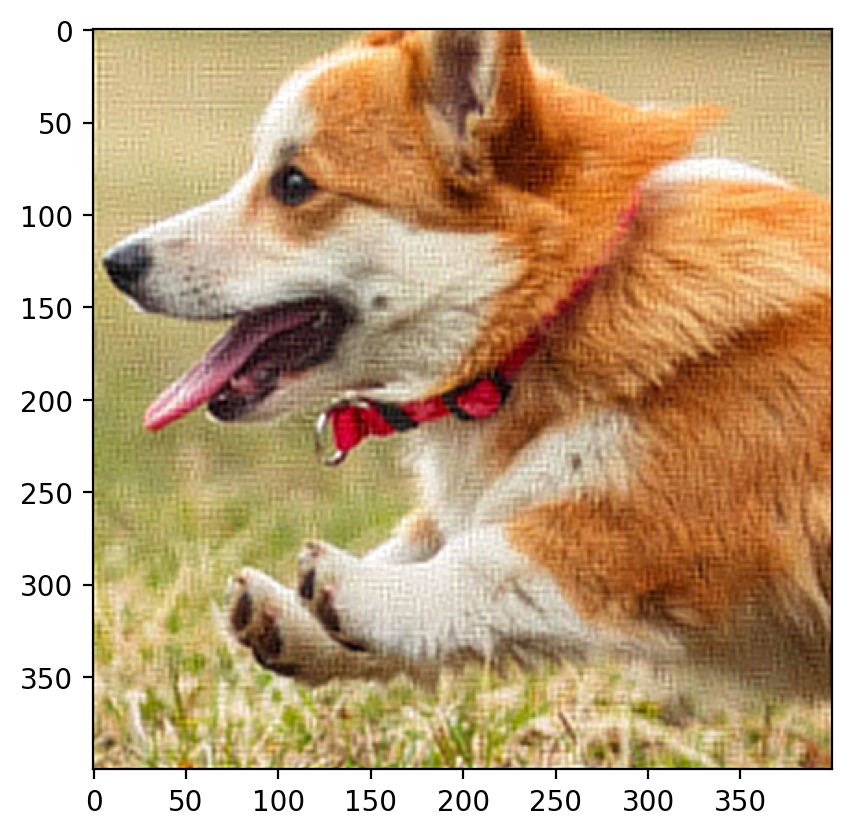

In [ ]:
plt.imshow(high_res_Y_pred)

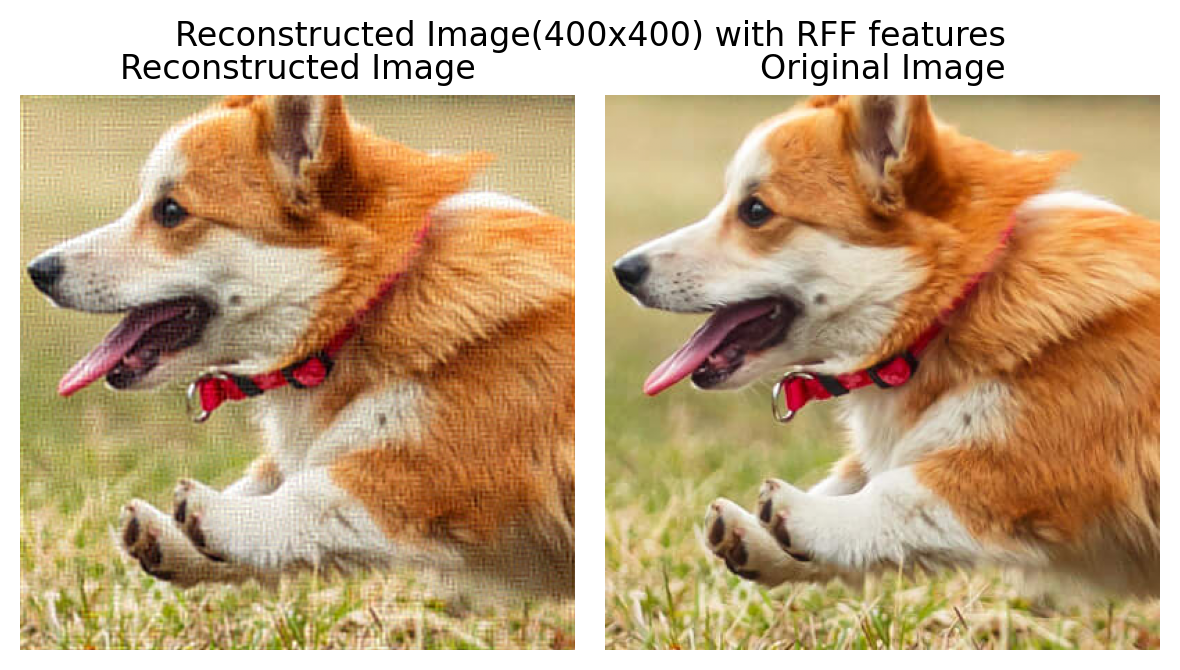

In [ ]:
# # results for 400x400 image
plot_reconstructed_and_original_image(crop, net, high_res_X_rff, title="Reconstructed Image(400x400) with RFF features")

In [ ]:
crop=crop.reshape(400,400,3)

2. The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics:
    - RMSE on predicted v/s ground truth high resolution image
    - Peak SNR on predicted v/s ground truth high resolution image

In [ ]:
# functions for calculating RMSE and PSNR

def compute_rmse(img1, img2):
    if isinstance(img1, torch.Tensor):
        img1 = img1.cpu().detach().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.cpu().detach().numpy()

    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    img1_flat = img1.flatten()
    img2_flat = img2.flatten()

    return np.sqrt(np.mean((img1_flat - img2_flat) ** 2))

def compute_psnr(original, predicted, max_pixel=1.0):
    if isinstance(original, torch.Tensor):
        original = original.cpu().detach().numpy()
    if isinstance(predicted, torch.Tensor):
        predicted = predicted.cpu().detach().numpy()
    mse = np.mean((original - predicted) ** 2)
    if mse == 0:
        return float('inf')

    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

rmse = compute_rmse(high_res_Y_pred, crop)
print(f'RMSE = {rmse}')

psnr = compute_psnr(crop, high_res_Y_pred)
print(f'PSNR = {psnr}')


RMSE = 0.3178618422495497
PSNR = 9.955232077445226
